<a href="https://colab.research.google.com/github/MSTarakanov/CNN_genre_classification/blob/master/CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Подключение основных библиотек

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import pylab

#### Импорт файлов с гугл диска

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


#### Проверка, что монтирование прошла успешно

In [ ]:
DIRS = os.listdir('/gdrive/My Drive/Colab Notebooks/')
DIRS

['Untitled0.ipynb',
 'mels',
 'CNN.ipynb',
 'IDP.ipynb',
 'CNN_PyTorch.ipynb',
 'train',
 'test',
 'final.pt']

### Работа с PyTorh

#### Подключение фреймворка

In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101


#### Определим основные переменные

In [ ]:
data_dir = '/gdrive/My Drive/Colab Notebooks/'
model_name = 'resnet'
num_classes = 10
batch_size = 8
num_epochs = 15
feature_extract = False

#### Описание трейн_модел

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
    
    if model_name == "resnet":
        """ RESNET 34
        """
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    return model_ft, input_size

#### Инициализация модели

In [ ]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer2.2.conv1.weight
	 layer2.2.bn1.weight
	 layer2.2.bn1.bias
	 layer2.2.conv2.weight
	 layer2.2.bn2.weight
	 layer2.2.bn2.bias
	 layer2.3.conv1.weight
	 layer2.3.bn1.weight
	 layer2.3.bn1.

In [ ]:
optimizer_ft = optim.Adam(params_to_update, lr=0.0001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [ ]:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.0571 Acc: 0.9833
test Loss: 1.3809 Acc: 0.6717

Epoch 1/14
----------
train Loss: 0.0404 Acc: 0.9892
test Loss: 1.6708 Acc: 0.6700

Epoch 2/14
----------
train Loss: 0.0413 Acc: 0.9888
test Loss: 1.2494 Acc: 0.7133

Epoch 3/14
----------
train Loss: 0.0498 Acc: 0.9867
test Loss: 1.7853 Acc: 0.6717

Epoch 4/14
----------
train Loss: 0.0406 Acc: 0.9896
test Loss: 1.8002 Acc: 0.6617

Epoch 5/14
----------
train Loss: 0.0246 Acc: 0.9946
test Loss: 1.6748 Acc: 0.6667

Epoch 6/14
----------
train Loss: 0.0339 Acc: 0.9904
test Loss: 1.6940 Acc: 0.6417

Epoch 7/14
----------
train Loss: 0.0606 Acc: 0.9825
test Loss: 1.8407 Acc: 0.6633

Epoch 8/14
----------
train Loss: 0.0227 Acc: 0.9950
test Loss: 1.6147 Acc: 0.6667

Epoch 9/14
----------
train Loss: 0.0106 Acc: 0.9979
test Loss: 1.5115 Acc: 0.6933

Epoch 10/14
----------
train Loss: 0.0204 Acc: 0.9942
test Loss: 1.6126 Acc: 0.6717

Epoch 11/14
----------
train Loss: 0.0278 Acc: 0.9913
test Loss: 1.8217 Acc: 0.6467

Epoch 12/14


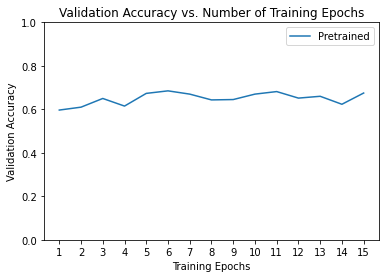

In [ ]:
ohist = [h.cpu().numpy() for h in hist]
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
torch.save(model_ft, '/gdrive/My Drive/Colab Notebooks/final.pt')